<h2>Sparse Googlenet</h2>
Submission by: <a href="https://github.com/id56">Mashrur Mahmud</a><br>
Model Overview: Weight Pruned Googlenet, trained with Cutout and Label Smoothing. 

In [45]:
import torch
import numpy as np
from torch import nn
from torch import optim
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.module import Module
from torch.optim.lr_scheduler import _LRScheduler
from torchvision import datasets,transforms, models

import matplotlib.pyplot as plt
from PIL import Image

import os
import sys
import time
import math

<h3>Hyperparameter Settings</h3>
I trained my model under the following hyperparameters:
<ul>
    <li>batch size = 128</li>
    <li>maximum epochs = 200 </li>
    <li>learning rate = 0.1</li>
    <li>warmup training epochs = 2</li>
    <li>train scheduling milestones = 60, 120, 160, 180, 200</li>
    <li>learning rate decay factor = 0.1 (reduced to a tenth, every milestone)</li>
    <li>cutout length = 8 (8x8 pixel square)
    <li>random seed = 56 (for reproducibility)</li>
</ul>

In [46]:
batchsize = 128
milestones = [60,120,160,180,200]
w = 2
torch.manual_seed(56)

In [47]:
### Set the directory of the final checkpoint and the location of CIFAR_100(where it is downloaded/to be downloaded)
### My directories are set in Kaggle style since I trained them on the kaggle cloud.

final_path = '../input/sparsegnet100/sparsegnetv5_200ep.pth'

download = False
data_dir='../input/cifar100/cifar-100-python/'

<h3>Loading and Preprocessing CIFAR100:</h3>
<p>I want to normalize the data as a part of my preprocessing. The code cell below calculates the mean and standard deviation along each color channel.</p>

In [48]:
#def compute_mean_std(dataset):
    
#    data_r = np.dstack([np.array(im)[:, :, 0]/255 for im,label in dataset])
#    data_g = np.dstack([np.array(im)[:, :, 1]/255 for im,label in dataset])
#    data_b = np.dstack([np.array(im)[:, :, 2]/255 for im,label in dataset])
    
#    mean = [np.asscalar(np.mean(data_r)), np.asscalar(np.mean(data_g)), np.asscalar(np.mean(data_b))]
#    std = [np.asscalar(np.std(data_r)), np.asscalar(np.std(data_g)), np.asscalar(np.std(data_b))]
    
#    return mean,std

In [49]:
#cifar_norm_train=datasets.CIFAR100(data_dir, train=True, transform=None, target_transform=None, download=False)
#cifar_norm_test=datasets.CIFAR100(data_dir, train=False, transform=None, target_transform=None, download=False)
#train_mean,train_std = compute_mean_std(cifar_norm_train)
#test_mean, test_std = compute_mean_std(cifar_norm_test)
#print(train_mean,train_std)
#print(test_mean,test_std)

Uncomment the above cells if you wish to determine normalization values yourself. I saved the resultant values below so that I don't have to run the above computation each time I use this model.

In [50]:
train_mean,train_std = [0.5070751592371341, 0.48654887331495067, 0.4409178433670344],[0.2673342858792403, 0.2564384629170882, 0.27615047132568393]
test_mean, test_std = [0.508796412760417, 0.48739301317401906, 0.4419422112438727],[0.2682515741720801, 0.25736373644781246, 0.2770957707973041]

Cutout implementation from [https://github.com/uoguelph-mlrg/Cutout](https://github.com/uoguelph-mlrg/Cutout).

In [51]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

Preprocessing steps:
<ul><li>padding with 4 zeros on each side, resulting in a 40 by 40 image</li>
    <li>taking 32 by 32 random crops</li>
    <li>random horizontal flipping</li>
    <li>applying cutout (8x8 px) </li>
    <li>normalization by values found above</li></ul>

In [52]:
train_transforms = transforms.Compose([transforms.Pad(4,fill=0),
                                     transforms.RandomResizedCrop(32),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(train_mean,train_std),
                                     Cutout(n_holes=1, length=8)])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(test_mean,test_std)])


cifar_train=datasets.CIFAR100(data_dir, train=True, transform=train_transforms, target_transform=None, download=download)
cifar_test=datasets.CIFAR100(data_dir, train=False, transform=test_transforms, target_transform=None, download=download)

trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(cifar_test, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True)

<h3>Visualizing CIFAR</h3>
<p>Just to see what's actually in there.</p>

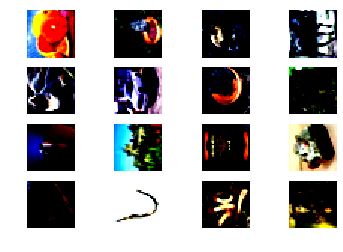

In [53]:
for images,labels in testloader:
    break
_, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i,j].axis('off')
        axarr[i,j].imshow(images[i*5+j].T)

<h3>Pruning</h3>
We'll prune two types of layers, according to Han et al. ('15) - the fully connected layers and convolutional layers. In googlenet, there is a single fc layer, and many conv layers as part of the inception module.

In [54]:
class MaskedConv2d(Module):
    r"""Applies a masked 2D convolution over an input signal composed of several input planes.
    
    In the simplest case, the output value of the layer with input size (N,C_in,H,W) and output
    (N,C_out,H_out,W_out) can be precisely described as:
    
    out(N_i,C_out_j) = bias(C_out_j) + ∑[k:0,C_in-1](weight(C_out_j,k)*input(N_i,k))
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding = 0, bias = True):
        super(MaskedConv2d, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.weight = Parameter(torch.Tensor(out_channels, in_channels, kernel_size,kernel_size))
        self.input_shape = 0
        # Initialize the mask with 1
        self.mask = Parameter(torch.ones([out_channels, in_channels, kernel_size,kernel_size]), requires_grad=False)
        
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1)*self.weight.size(2)*self.weight.size(3))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        self.input_shape = input.shape[2]
        return F.conv2d(input, self.weight * self.mask, self.bias, padding = self.padding)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_channels=' + str(self.in_channels) \
            + ', out_channels=' + str(self.out_channels) \
            + ', kernel_size=' + str(self.kernel_size) \
            + ', bias=' + str(self.bias is not None) + ')'

    def prune(self, threshold):
        weight_dev = self.weight.device
        mask_dev = self.mask.device
        # Convert Tensors to numpy and calculate
        tensor = self.weight.data.cpu().numpy()
        mask = self.mask.data.cpu().numpy()
        new_mask = np.where(abs(tensor) < threshold, 0, mask)
        # Apply new weight and mask
        self.weight.data = torch.from_numpy(tensor * new_mask).to(weight_dev)
        self.mask.data = torch.from_numpy(new_mask).to(mask_dev)

In [55]:
class MaskedLinear(Module):
    r"""Applies a masked linear transformation to the incoming data: y = (A * M)x + b`
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
    Shape:
        - Input: :math:`(N, *, in\_features)` where `*` means any number of
          additional dimensions
        - Output: :math:`(N, *, out\_features)` where all but the last dimension
          are the same shape as the input.
    Attributes:
        weight: the learnable weights of the module of shape
            (out_features x in_features)
        bias:   the learnable bias of the module of shape (out_features)
        mask: the unlearnable mask for the weight.
            It has the same shape as weight (out_features x in_features)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        # Initialize the mask with 1
        self.mask = Parameter(torch.ones([out_features, in_features]), requires_grad=False)
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.linear(input, self.weight * self.mask, self.bias)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) \
            + ', bias=' + str(self.bias is not None) + ')'

    def prune(self, threshold):
        weight_dev = self.weight.device
        mask_dev = self.mask.device
        # Convert Tensors to numpy and calculate
        tensor = self.weight.data.cpu().numpy()
        mask = self.mask.data.cpu().numpy()
        new_mask = np.where(abs(tensor) < threshold, 0, mask)
        # Apply new weight and mask
        self.weight.data = torch.from_numpy(tensor * new_mask).to(weight_dev)
        self.mask.data = torch.from_numpy(new_mask).to(mask_dev)

In [56]:
 def prune_by_std(layer, s=0.25):
    """
    s is a quality parameter that is multiplied with the standard dev of a layer to determine threshold.

    """
    for name, module in net.named_modules():
        if layer in str(type(module)):
            threshold = np.std(module.weight.data.cpu().numpy()) * s
            print(f'Pruning with threshold : {threshold} for layer {name}')
            module.prune(threshold)

<h3> The Network</h3>
Baseline googlenet from <a href="https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/googlenet.py">this repository.</a>

In [57]:
class Inception(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj, mask=False):
        super().__init__()
        
        Conv2d = MaskedConv2d if mask else nn.Conv2d
        
        #1x1conv branch
        self.b1 = nn.Sequential(
            Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        #1x1conv -> 3x3conv branch
        self.b2 = nn.Sequential(
            Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        #1x1conv -> 5x5conv branch
        #we use 2 3x3 conv filters stacked instead
        #of 1 5x5 filters to obtain the same receptive
        #field with fewer parameters
        self.b3 = nn.Sequential(
            Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5, n5x5),
            nn.ReLU(inplace=True),
            Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        #3x3pooling -> 1x1conv
        #same conv
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            Conv2d(input_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogleNet(nn.Module):

    def __init__(self, num_class=100, mask = False):
        super().__init__()
        linear = MaskedLinear if mask else nn.Linear
        Conv2d = MaskedConv2d if mask else nn.Conv2d
        
        self.prelayer = nn.Sequential(
            Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True)
        )

        #although we only use 1 conv layer as prelayer,
        #we still use name a3, b3.......
        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32, mask = mask)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64, mask = mask)

        #"""In general, an Inception network is a network consisting of
        #modules of the above type stacked upon each other, with occasional 
        #max-pooling layers with stride 2 to halve the resolution of the 
        #grid"""
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64, mask = mask)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64, mask = mask)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64, mask = mask)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64, mask = mask)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128, mask = mask)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128, mask = mask)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128, mask = mask)

        #input feature size: 8*8*1024
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = linear(1024, num_class)
    
    def forward(self, x):
        output = self.prelayer(x)
        output = self.a3(output)
        output = self.b3(output)
        
        output = self.maxpool(output)

        output = self.a4(output)
        output = self.b4(output)
        output = self.c4(output)
        output = self.d4(output)
        output = self.e4(output)

        output = self.maxpool(output)

        output = self.a5(output)
        output = self.b5(output)

        #"""It was found that a move from fully connected layers to
        #average pooling improved the top-1 accuracy by about 0.6%, 
        #however the use of dropout remained essential even after 
        #removing the fully connected layers."""
        
        output = self.avgpool(output)
        output = self.dropout(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)

        return output

def googlenet(mask=False):
    return GoogleNet(mask=mask)

<h3>Checking the baseline</h3>

In [58]:
def print_nonzeros(model):
    #param_bits = 32
    nonzero = total = 0
    for name, p in model.named_parameters():
        if 'mask' in name:
            continue
        tensor = p.data.cpu().numpy()
        nz_count = (np.count_nonzero(tensor))
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        sparsity = 1-nz_count/total_params
        print(f'{name:20} | total = {total_params/2:7} | params = {nz_count/2:7} | sparsity = {sparsity:6.2f} | shape = {tensor.shape}')
    print('Total:',total,'Alive:',nonzero)
    return(total)



In [59]:
net = googlenet(mask = True)
print_nonzeros(net)

prelayer.0.weight    | total =  2592.0 | params =  2592.0 | sparsity =   0.00 | shape = (192, 3, 3, 3)
prelayer.0.bias      | total =    96.0 | params =    96.0 | sparsity =   0.00 | shape = (192,)
prelayer.1.weight    | total =    96.0 | params =    96.0 | sparsity =   0.00 | shape = (192,)
prelayer.1.bias      | total =    96.0 | params =     0.0 | sparsity =   1.00 | shape = (192,)
a3.b1.0.weight       | total =  6144.0 | params =  6144.0 | sparsity =   0.00 | shape = (64, 192, 1, 1)
a3.b1.0.bias         | total =    32.0 | params =    32.0 | sparsity =   0.00 | shape = (64,)
a3.b1.1.weight       | total =    32.0 | params =    32.0 | sparsity =   0.00 | shape = (64,)
a3.b1.1.bias         | total =    32.0 | params =     0.0 | sparsity =   1.00 | shape = (64,)
a3.b2.0.weight       | total =  9216.0 | params =  9216.0 | sparsity =   0.00 | shape = (96, 192, 1, 1)
a3.b2.0.bias         | total =    48.0 | params =    48.0 | sparsity =   0.00 | shape = (96,)
a3.b2.1.weight       | total

6258500

The baseline unpruned model has 6258500 params.

<h2>Scoring</h2>

In [60]:
def get_sparse_size(tensor_shape, param_bits=32, sparsity=0):
    n_elements = np.prod(tensor_shape)
    c_size = n_elements * param_bits * (1 - sparsity)
    if sparsity > 0:
        c_size += n_elements  # 1 bit binary mask.
    return c_size


def get_conv_output_size(image_size, filter_size, stride, padding):
    out_size = np.ceil((image_size - filter_size + 1. + 2 * padding) / stride)
    return int(out_size)

In [61]:
def count_ops(op, input_shape, param_bits=32, sparsity=0):
    c_in,resolution = input_shape
    flop_mults = flop_adds = param_count = 0
    
    if isinstance(op, MaskedConv2d):
        
        resolution = op.input_shape
        k_size = op.kernel_size
        c_in = op.in_channels
        c_out = op.out_channels
        x =  get_sparse_size([k_size, k_size, c_in, c_out], param_bits, sparsity)
        #print(x)
        param_count+=x
        stride = 1
        vector_length = (k_size * k_size * c_in) * (1 - sparsity)
        out_size = get_conv_output_size(resolution, k_size, stride, op.padding)
        n_output_elements =  out_size**2 * c_out
        
        # Each output is the product of a one dot product. Dot product of two
        # vectors of size n needs n multiplications and n - 1 additions.
        flop_mults += vector_length * n_output_elements
        flop_adds += (vector_length - 1) * n_output_elements

        if type(op.bias)!=type(None):
          # For each output channel we need a bias term.
          param_count += c_out * param_bits
          # If we have bias we need one more addition per dot product.
          flop_adds += n_output_elements
            
        out_shape = (c_out,out_size)
    
    elif isinstance(op,nn.ReLU):
        n_muls = 1
        n_adds = 0
        flop_mults += n_muls*(c_in*resolution*resolution)
        flop_adds += n_adds*(c_in*resolution*resolution)
        out_shape = input_shape
 
    elif isinstance(op, nn.AdaptiveAvgPool2d):
        # For each output channel we will make a division.
        flop_mults += c_in
        # We have to add values over spatial dimensions.
        flop_adds += (resolution * resolution - 1) * c_in
        out_size=op.output_size[0]
        out_shape = (c_in,out_size)
    
    elif isinstance(op, nn.MaxPool2d):
        # For each output channel we will make max.
        flop_mults += c_in
        # We have to add values over spatial dimensions.
        flop_adds += (resolution * resolution - 1) * c_in
        out_size=get_conv_output_size(resolution, op.kernel_size, op.stride, op.padding)
        out_shape = (c_in,out_size)
        
    elif isinstance(op, MaskedLinear):
        c_in, c_out = op.in_features,op.out_features
        param_count += get_sparse_size([c_in, c_out], param_bits, sparsity)
        
        n_elements = c_in * (1 - sparsity)
        flop_mults += n_elements * c_out

        flop_adds += (n_elements - 1) * c_out
        out_shape=input_shape
        if type(op.bias)!=type(None):
            param_count += c_out * param_bits
            flop_adds += c_out
            
    elif isinstance(op,nn.BatchNorm2d):     #Batch Norm does not require any flops as it is merged into conv
        c_in = c_out = op.num_features
        param_count += get_sparse_size([c_in], param_bits, sparsity)
        n_elements = c_in * (1 - sparsity)
        flop_mults = 0
        flop_adds = 0
        out_size = input_shape
        if type(op.bias)!=type(None):
            param_count += c_out * param_bits
            flop_adds += c_out
        out_shape = input_shape
        
    elif isinstance(op,nn.Dropout2d):  #Nothing for Dropout
        return 0,0,0,(c_in,resolution)
    
    else:
        raise ValueError('Encountered unknown operation %s.' % str(op))
    return param_count, flop_mults, flop_adds,out_shape



In [62]:
def calculate_total_paramflops(param_bits):
    totalparams=0
    totalbits=0
    totalmults=0
    totaladds=0
    input_shape = (3,32)
    for name, op in ops:
        sp = 0
        if isinstance(op,MaskedLinear) or isinstance(op,MaskedConv2d):
            wname = name+'.weight'
            weight_tensor = model_dict[wname]
            actual_size = np.prod(weight_tensor.shape)
            non_zeros = np.count_nonzero(weight_tensor.numpy())
            sp = 1 - non_zeros/actual_size
        
        bit_count,mults,adds,out_shape = count_ops(op,input_shape,param_bits = param_bits, sparsity = sp)
        print(name,' | bits:',bit_count,' | params:',bit_count/32,'| sparsity:',sp,' | mults:',mults,' | adds',adds)
        totalbits +=bit_count
        totalparams +=bit_count/32
        totalmults+= mults
        totaladds+=adds
        input_shape = out_shape
    print('_'*80,'\n')
    print('Total bits:',totalbits,'| Total params:',totalparams,'| Total Mult-Adds:',(totalmults+totaladds))
    print('Total (Mbytes):',totalbits/8/1e6,'| Total params(M):',totalparams/1e6,'| Total Mult-Adds(B):',(totalmults+totaladds)/1e9)
    return totalbits,totalparams,totalmults,totaladds

### Testing the scorer:

In [63]:
a = torch.randn(1,3,32,32)
test = net(a)
ops = [(name,module) for name,module in net.named_modules() if type(module) not in [GoogleNet, Inception, nn.Sequential]]

In [64]:
model_dict = net.state_dict()
calculate_total_paramflops(32)

prelayer.0  | bits: 172032.0  | params: 5376.0 | sparsity: 0.0  | mults: 5308416.0  | adds 5308416.0
prelayer.1  | bits: 12288  | params: 384.0 | sparsity: 0  | mults: 0  | adds 192
prelayer.2  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 196608  | adds 0
a3.b1.0  | bits: 395264.0  | params: 12352.0 | sparsity: 0.0  | mults: 12582912.0  | adds 12582912.0
a3.b1.1  | bits: 4096  | params: 128.0 | sparsity: 0  | mults: 0  | adds 64
a3.b1.2  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 65536  | adds 0
a3.b2.0  | bits: 592896.0  | params: 18528.0 | sparsity: 0.0  | mults: 18874368.0  | adds 18874368.0
a3.b2.1  | bits: 6144  | params: 192.0 | sparsity: 0  | mults: 0  | adds 96
a3.b2.2  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 98304  | adds 0
a3.b2.3  | bits: 3543040.0  | params: 110720.0 | sparsity: 0.0  | mults: 113246208.0  | adds 113246208.0
a3.b2.4  | bits: 8192  | params: 256.0 | sparsity: 0  | mults: 0  | adds 128
a3.b2.5  | bits: 0  | params: 0.0 | sparsity: 0  | mults

a5.b2.3  | bits: 14755840.0  | params: 461120.0 | sparsity: 0.0  | mults: 29491200.0  | adds 29491200.0
a5.b2.4  | bits: 20480  | params: 640.0 | sparsity: 0  | mults: 0  | adds 320
a5.b2.5  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 20480  | adds 0
a5.b3.0  | bits: 852992.0  | params: 26656.0 | sparsity: 0.0  | mults: 1703936.0  | adds 1703936.0
a5.b3.1  | bits: 2048  | params: 64.0 | sparsity: 0  | mults: 0  | adds 32
a5.b3.2  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 2048  | adds 0
a5.b3.3  | bits: 1183744.0  | params: 36992.0 | sparsity: 0.0  | mults: 2359296.0  | adds 2359296.0
a5.b3.4  | bits: 8192  | params: 256.0 | sparsity: 0  | mults: 0  | adds 128
a5.b3.5  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 8192  | adds 0
a5.b3.6  | bits: 4722688.0  | params: 147584.0 | sparsity: 0.0  | mults: 9437184.0  | adds 9437184.0
a5.b3.7  | bits: 8192  | params: 256.0 | sparsity: 0  | mults: 0  | adds 128
a5.b3.8  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 8192  | add

(200272000.0, 6258500.0, 1524404144.0, 1522170672.0)

<p>Baseline model has 6.26M params and 3.04B mult-adds.</p>


<h3> Calculating Final Score:</h3>
<p>Scoring the final checkpoint (With Freebie Quantization):</p>

In [65]:
score_checkpoint = torch.load(final_path)
net.load_state_dict(score_checkpoint['model_state_dict'])
model_dict = net.state_dict()
totalbits,totalparams,totalmults,totaladds = calculate_total_paramflops(16)

prelayer.0  | bits: 60480.0  | params: 1890.0 | sparsity: 0.37037037037037035  | mults: 3342336.0  | adds 3342336.0
prelayer.1  | bits: 6144  | params: 192.0 | sparsity: 0  | mults: 0  | adds 192
prelayer.2  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 196608  | adds 0
a3.b1.0  | bits: 120688.0  | params: 3771.5 | sparsity: 0.453857421875  | mults: 6872064.0  | adds 6872064.0
a3.b1.1  | bits: 2048  | params: 64.0 | sparsity: 0  | mults: 0  | adds 64
a3.b1.2  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 65536  | adds 0
a3.b2.0  | bits: 196880.0  | params: 6152.5 | sparsity: 0.40011935763888884  | mults: 11322368.0  | adds 11322368.0
a3.b2.1  | bits: 3072  | params: 96.0 | sparsity: 0  | mults: 0  | adds 96
a3.b2.2  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 98304  | adds 0
a3.b2.3  | bits: 1081488.0  | params: 33796.5 | sparsity: 0.4524649160879629  | mults: 62006272.00000001  | adds 62006272.00000001
a3.b2.4  | bits: 4096  | params: 128.0 | sparsity: 0  | mults: 0  | adds

e4.b3.8  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 32768  | adds 0
e4.b4.0  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 128  | adds 32640
e4.b4.1  | bits: 673376.0  | params: 21043.0 | sparsity: 0.4416725852272727  | mults: 9659904.0  | adds 9659904.0
e4.b4.2  | bits: 4096  | params: 128.0 | sparsity: 0  | mults: 0  | adds 128
e4.b4.3  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 32768  | adds 0
a5.b1.0  | bits: 1705632.0  | params: 53301.0 | sparsity: 0.5632042518028846  | mults: 5954176.0  | adds 5954176.0
a5.b1.1  | bits: 8192  | params: 256.0 | sparsity: 0  | mults: 0  | adds 256
a5.b1.2  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 16384  | adds 0
a5.b2.0  | bits: 1250032.0  | params: 39063.5 | sparsity: 0.47681039663461533  | mults: 4457408.0  | adds 4457408.0
a5.b2.1  | bits: 5120  | params: 160.0 | sparsity: 0  | mults: 0  | adds 160
a5.b2.2  | bits: 0  | params: 0.0 | sparsity: 0  | mults: 10240  | adds 0
a5.b2.3  | bits: 4654112.0  | params: 145441.0 | spa

In [66]:
final_score = (totalparams/(36.5*1e6)) + ((totalmults+totaladds)/(10.49*1e9))
print('Final Score: ', final_score)

Final Score:  0.2057170217506562


The final score is 0.2057 {1.84M params, 1.62B mult-adds}

<h3>Evaluation and Training Utilities</h3>

In [67]:
def eval_training():
    net.eval()

    test_loss = 0.0 # cost function error
    correct = 0.0
    k= 0
    with torch.no_grad():
        for images, labels in testloader:
            images = Variable(images)
            labels = Variable(labels)
            images = images.cuda()
            labels = labels.cuda()
            temp = net(images)
            loss = loss_function(temp, labels)
            test_loss += loss.item()
            _, preds = temp.max(1)
            del temp
            torch.cuda.empty_cache()
            x= preds.eq(labels).sum()
            print(x)
            correct = correct+x
        k=k+1
        if k%10 == 0:
            print(k)

    print('Test set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(
        test_loss / len(trainloader.dataset),
        correct.float() / len(testloader.dataset)
    ))
    return correct.float() / len(testloader.dataset)

In [68]:
def train(initial_epoch,final_epoch):
    net.train()
    for epoch in range(initial_epoch,final_epoch):  
        if epoch > w:
            train_scheduler.step(epoch)
        for batch_index, (data, target) in enumerate(trainloader):
            if epoch <= w:
                warmup_scheduler.step()
                print('warmed up')
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = net(data)
            loss = loss_function(output, target)
            loss.backward()

            # zero-out all the gradients corresponding to the pruned connections
            for name, p in net.named_parameters():
                if 'mask' in name:
                    continue
                tensor = p.data.cpu().numpy()
                grad_tensor = p.grad.data.cpu().numpy()
                grad_tensor = np.where(tensor==0, 0, grad_tensor)
                p.grad.data = torch.from_numpy(grad_tensor).cuda()

            optimizer.step()
            
            print('Training Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tLR: {:0.6f}'.format(
            loss.item(),
            optimizer.param_groups[0]['lr'],
            epoch=epoch,
            trained_samples=batch_index * batchsize + len(data),
            total_samples=len(trainloader.dataset)
            ))


In [69]:
class WarmUpLR(_LRScheduler):
    """warmup_training learning rate scheduler
    Args:
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):
        
        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """we will use the first m batches, and set the learning
        rate to base_lr * m / total_iters
        """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

In [70]:
def LabelSmoothedCrossEntropy(preds, labels, epsilon = 0.1, num_classes = 100):
    one_hot = torch.zeros_like(preds).scatter(1, labels.view(-1, 1), 1)
    one_hot = one_hot*(1-epsilon) + (1-one_hot)*epsilon/(num_classes-1)
    log_prb = F.log_softmax(preds, dim=1)
    loss = -(one_hot * log_prb).sum(dim=1)
    return loss.mean()

<h3>Accuracy Evaluation</h3>

In [71]:
score_checkpoint = torch.load(final_path)
net = googlenet(mask = True)
net.load_state_dict(score_checkpoint['model_state_dict'])
net = net.cuda()

loss_function = LabelSmoothedCrossEntropy
eval_training()

tensor(102, device='cuda:0')
tensor(103, device='cuda:0')
tensor(98, device='cuda:0')
tensor(99, device='cuda:0')
tensor(101, device='cuda:0')
tensor(102, device='cuda:0')
tensor(98, device='cuda:0')
tensor(96, device='cuda:0')
tensor(106, device='cuda:0')
tensor(105, device='cuda:0')
tensor(105, device='cuda:0')
tensor(102, device='cuda:0')
tensor(105, device='cuda:0')
tensor(102, device='cuda:0')
tensor(105, device='cuda:0')
tensor(105, device='cuda:0')
tensor(110, device='cuda:0')
tensor(105, device='cuda:0')
tensor(105, device='cuda:0')
tensor(101, device='cuda:0')
tensor(94, device='cuda:0')
tensor(98, device='cuda:0')
tensor(101, device='cuda:0')
tensor(101, device='cuda:0')
tensor(108, device='cuda:0')
tensor(100, device='cuda:0')
tensor(112, device='cuda:0')
tensor(100, device='cuda:0')
tensor(105, device='cuda:0')
tensor(102, device='cuda:0')
tensor(101, device='cuda:0')
tensor(105, device='cuda:0')
tensor(100, device='cuda:0')
tensor(100, device='cuda:0')
tensor(105, device='

tensor(0.8018, device='cuda:0')

<h3>Training method</h3>

In [72]:
resume_training = False
#Set resume directory here if trained over multiple sessions
model_path = ''
if resume_training:
    checkpoint = torch.load(model_path)

In [73]:
net = googlenet(mask = True)
if resume_training:
    net.load_state_dict(checkpoint['model_state_dict'])
net = net.cuda()

loss_function = LabelSmoothedCrossEntropy
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
if resume_training:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.2) #learning rate decay
if not resume_training:
    iter_per_epoch = len(trainloader)
    warmup_scheduler = WarmUpLR(optimizer, iter_per_epoch * w)


In [ ]:
train(1,101) # Building connections

num_prunings = 6

for i in range(num_prunings):   #Alternate conv and linear iterative pruning and retraining for two epochs
    layer_type = 'Conv' if i%2==0 else 'Linear'
    prune_by_std(layer_type)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    if i==num_prunings-1:
        break
    train(101+i*2,103+i*2)
    
train(101+i*2,151)  # Strengthening connections again

for i in range(num_prunings):   #Alternate conv and linear iterative pruning and retraining for two epochs
    layer_type = 'Conv' if i%2==0 else 'Linear'
    prune_by_std(layer_type)
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    if i==num_prunings-1:
        break
    train(151+i*2,153+i*2)
    
train(151+i*2,201)

In [75]:
torch.save({
            'epoch': 200,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'sparsegnetv5_200ep.pth')
print('saved')

saved


<pre>

[1] 'Going Deeper with Convolutions', Szegedy et al. (2015)
    <a href="https://arxiv.org/abs/1409.4842">https://arxiv.org/abs/1409.4842</a>

[2] 'Learning both Weights and Connections for Efficient Neural Networks', Han et al. (2015)
    <a href="https://arxiv.org/abs/1506.02626">https://arxiv.org/abs/1506.02626</a>

[3] 'Improved Regularization of Convolutional Neural Networks with Cutout', T DeVries et al. (2017)
    <a href="https://arxiv.org/abs/1708.04552">https://arxiv.org/abs/1506.02626</a>
</pre>